In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from pytorch_grad_cam import GradCAM

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')

In [4]:
#ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_GroundTruth2.csv')
#ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_GroundTruth2.csv')

ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_umap_skincancer_onehot.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_umap_skincancer_onehot.csv')

In [5]:
mask_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/masks')
mask_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/masks')

In [6]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [7]:
#train_ids

In [8]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, mask_dir, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        mask = np.array(Image.open(self.mask_dir / f"{name}_segmentation.png").convert("L"))
        mask = self.to_tensor(mask)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][list(ground_truth_df.columns[1:])].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)

        return image, ground_truth, mask

In [9]:
batch_size = 16

In [10]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids, mask_dir_train)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids, mask_dir_test)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0706, 0.0784],
          [0.0314, 0.0196, 0.1529,  ..., 0.2392, 0.0627, 0.0784],
          [0.0275, 0.0314, 0.3412,  ..., 0.4392, 0.0863, 0.0706],
          ...,
          [0.3922, 0.3490, 0.3412,  ..., 0.4824, 0.4627, 0.4471],
          [0.3961, 0.3451, 0.3451,  ..., 0.5059, 0.4941, 0.4196],
          [0.2784, 0.3451, 0.3451,  ..., 0.4941, 0.4706, 0.2706]],

         [[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0745, 0.0824],
          [0.0314, 0.0196, 0.1412,  ..., 0.2314, 0.0627, 0.0784],
          [0.0314, 0.0314, 0.3137,  ..., 0.4235, 0.0863, 0.0706],
          ...,
          [0.3137, 0.2471, 0.2275,  ..., 0.4588, 0.4353, 0.4235],
          [0.3529, 0.2392, 0.2275,  ..., 0.4863, 0.4745, 0.4039],
          [0.2549, 0.2431, 0.2314,  ..., 0.4706, 0.4471, 0.2588]],

         [[0.0314, 0.0314, 0.0353,  ..., 0.1137, 0.0784, 0.0902],
          [0.0314, 0.0196, 0.1412,  ..., 0.2353, 0.0706, 0.0863],
          [0.0314, 0.0353, 0.3176,  ..., 

In [12]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.3255, 0.3451, 0.3608,  ..., 0.2824, 0.2706, 0.2549],
          [0.3373, 0.3647, 0.3843,  ..., 0.2980, 0.2824, 0.2588],
          [0.3529, 0.3804, 0.4039,  ..., 0.3137, 0.2941, 0.2706],
          ...,
          [0.4314, 0.4588, 0.4667,  ..., 0.3882, 0.3765, 0.3569],
          [0.4235, 0.4471, 0.4588,  ..., 0.3843, 0.3647, 0.3490],
          [0.4196, 0.4353, 0.4471,  ..., 0.3765, 0.3569, 0.3333]],

         [[0.3176, 0.3373, 0.3569,  ..., 0.2627, 0.2353, 0.2157],
          [0.3294, 0.3569, 0.3804,  ..., 0.2784, 0.2431, 0.2196],
          [0.3490, 0.3725, 0.4000,  ..., 0.2824, 0.2549, 0.2314],
          ...,
          [0.4353, 0.4431, 0.4431,  ..., 0.3922, 0.3686, 0.3490],
          [0.4157, 0.4235, 0.4314,  ..., 0.3843, 0.3569, 0.3373],
          [0.4000, 0.4039, 0.4157,  ..., 0.3804, 0.3490, 0.3255]],

         [[0.3216, 0.3412, 0.3490,  ..., 0.2471, 0.2275, 0.2078],
          [0.3333, 0.3608, 0.3725,  ..., 0.2627, 0.2353, 0.2118],
          [0.3490, 0.3725, 0.3961,  ..., 

In [13]:
for i, item in enumerate(train_loader):
    print(item[1].shape)
    print(item[1])
    if i == 0:
        break

torch.Size([16, 4])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


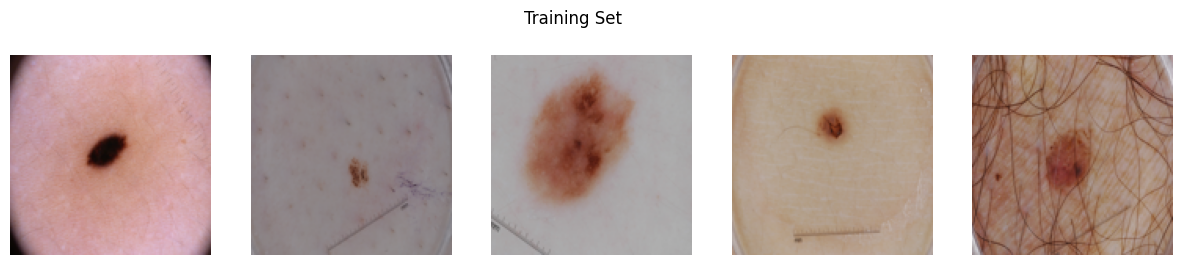

In [14]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, _, _) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [15]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(192)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(384)
        self.relu3 = torch.nn.LeakyReLU()

        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.relu4 = torch.nn.LeakyReLU()

        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(256 * 3 * 3, 1024)
        self.relu6 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.2)

        self.fc2 = torch.nn.Linear(1024, 512)
        self.relu7 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.1)

        self.fc3 = torch.nn.Linear(512, 4)
        #self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.pool3(self.relu5(self.bn5(self.conv5(x))))
        
        x = self.flatten(x)

        x = self.relu6(self.fc1(x))
        #x = self.dropout1(x)

        x = self.relu7(self.fc2(x))
        #x = self.dropout2(x)

        x = self.fc3(x)
        return x
    
# create model
model = CustomCNN().to(device)
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyRe

In [16]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[-0.1470, -0.3480, -0.0174,  0.1103]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [17]:
# test model with the first batch of the training data
for i, (image, ground_truth, _) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    ground_truth = ground_truth.to(device)
    output = model(image)
    # convert output to tensor with 1 on the predicted class and 0 on the other classes
    _, predicted_max = torch.max(output, 1)
    print(output)
    output = torch.zeros_like(output)
    output[torch.arange(output.size(0)), predicted_max] = 1
    print(output)
    print(ground_truth)
    print(ground_truth.shape)

tensor([[-0.0560, -0.3230,  0.1162,  0.0721],
        [-0.0065, -0.2579,  0.1242,  0.1139],
        [-0.0587, -0.3854, -0.0549,  0.0285],
        [-0.0992, -0.2817, -0.0877,  0.0683],
        [-0.0073, -0.2890,  0.0801,  0.2142],
        [-0.0429, -0.2627,  0.0226,  0.0519],
        [-0.1344, -0.2531,  0.0306,  0.1387],
        [-0.0569, -0.2372,  0.0053,  0.0607],
        [-0.0266, -0.3384,  0.0846, -0.0088],
        [-0.0407, -0.2926, -0.0746,  0.0677],
        [-0.0887, -0.2683,  0.0295,  0.0470],
        [-0.0602, -0.2919, -0.0179,  0.0998],
        [-0.0451, -0.2981,  0.0336, -0.0617],
        [-0.0142, -0.3206,  0.0470,  0.0942],
        [-0.1573, -0.3864,  0.1289,  0.1097],
        [-0.0100, -0.3206,  0.0302,  0.0391]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
     

In [18]:
#import torchvision.models as models
#
#model = models.resnet18(pretrained=True)
#model.fc = torch.nn.Linear(512, 6)  # Change final layer for 3-class classification
#model = model.to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) #, weight=torch.tensor([(2000/374), (2000/254), (2000/1372)], device=device)

# train the model
accumulation_steps = 4
model.train()
for epoch in range(50):
    #if epoch == 1:
    #    break
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)

    optimizer.zero_grad()

    for i, (images, ground_truth, _) in enumerate(train_loader):
        images, ground_truth = images.to(device), ground_truth.to(device)
        #ground_truth = ground_truth.float()
        
        outputs = model(images)
        #loss = criterion(outputs, ground_truth)
        #print(ground_truth)
        loss = criterion(outputs, ground_truth.argmax(dim=1))#(((outputs - ground_truth)* tensor_weights)**2).mean()
        #print("outputs")
        #print(outputs)

        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        predictions = torch.argmax(outputs, dim=1)
        #print("predictions")
        #print(predictions)
        #print("ground_truth")
        #print(ground_truth)

        #optimizer.step()
        
        accuracy = (predictions == ground_truth.argmax(dim=1)).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 0.7708761959075928, Accuracy: 0.7655
Epoch 2, Loss: 0.6355470123291016, Accuracy: 0.8455
Epoch 3, Loss: 0.6285935659408569, Accuracy: 0.841
Epoch 4, Loss: 0.5916633667945862, Accuracy: 0.8585
Epoch 5, Loss: 0.5868296983242035, Accuracy: 0.8685
Epoch 6, Loss: 0.578356388092041, Accuracy: 0.872
Epoch 7, Loss: 0.5772352924346924, Accuracy: 0.867
Epoch 8, Loss: 0.5490893182754517, Accuracy: 0.891
Epoch 9, Loss: 0.5079569833278657, Accuracy: 0.9165
Epoch 10, Loss: 0.5334377601146698, Accuracy: 0.9005
Epoch 11, Loss: 0.5528587439060211, Accuracy: 0.884
Epoch 12, Loss: 0.5393984189033508, Accuracy: 0.899
Epoch 13, Loss: 0.543531706571579, Accuracy: 0.897
Epoch 14, Loss: 0.5134994628429412, Accuracy: 0.9135
Epoch 15, Loss: 0.5085367450714111, Accuracy: 0.913
Epoch 16, Loss: 0.5153303544521332, Accuracy: 0.9045
Epoch 17, Loss: 0.5553282840251923, Accuracy: 0.891
Epoch 18, Loss: 0.513470725774765, Accuracy: 0.913
Epoch 19, Loss: 0.4822671043872833, Accuracy: 0.9315
Epoch 20, Loss:

In [20]:
# evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for images, ground_truth, _ in test_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        prediction_list = [0, 0, 0, 0, 0, 0]
        prediction_list[predicted.cpu().numpy()[0]] = 1
        predictions.append(prediction_list)

In [21]:
df_predicted = pd.DataFrame(predictions, columns=["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4", "cluster_5"], index=test_ids)
df_predicted = df_predicted.sort_index()
df_predicted

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
ISIC_0012086,0,0,1,0,0,0
ISIC_0012092,0,0,1,0,0,0
ISIC_0012095,1,0,0,0,0,0
ISIC_0012134,0,0,1,0,0,0
ISIC_0012136,1,0,0,0,0,0
...,...,...,...,...,...,...
ISIC_0016068,1,0,0,0,0,0
ISIC_0016069,0,0,1,0,0,0
ISIC_0016070,0,0,1,0,0,0
ISIC_0016071,1,0,0,0,0,0


In [22]:
df_predicted.sum()

cluster_0    153
cluster_1     73
cluster_2    223
cluster_3    151
cluster_4      0
cluster_5      0
dtype: int64

In [23]:
df_ground_truth = pd.read_csv(ground_truth_file_test, index_col='image_id')
df_ground_truth

,cluster_0,cluster_1,cluster_2,cluster_3
image_id,,,,
ISIC_0016028,1,0,0,0
ISIC_0014944,0,0,0,1
ISIC_0015990,0,0,1,0
ISIC_0016057,0,0,1,0
ISIC_0015089,0,0,0,1
...,...,...,...,...
ISIC_0015215,0,1,0,0
ISIC_0015142,0,0,0,1
ISIC_0016015,0,0,1,0


In [24]:
df_ground_truth.sum()

cluster_0    161
cluster_1     67
cluster_2    213
cluster_3    159
dtype: int64

In [25]:
# print mean absolute error
print("Mean Absolute Error:")
print((df_predicted - df_ground_truth).abs().mean())

Mean Absolute Error:
cluster_0    0.093333
cluster_1    0.040000
cluster_2    0.063333
cluster_3    0.043333
cluster_4         NaN
cluster_5         NaN
dtype: float64


In [27]:
labels_predicted = df_predicted[["cluster_0", "cluster_1", "cluster_2", "cluster_3"]].idxmax(axis=1)
labels_ground_truth = df_ground_truth[["cluster_0", "cluster_1", "cluster_2", "cluster_3"]].idxmax(axis=1)

In [28]:
labels_predicted

ISIC_0012086    cluster_2
ISIC_0012092    cluster_2
ISIC_0012095    cluster_0
ISIC_0012134    cluster_2
ISIC_0012136    cluster_0
                  ...    
ISIC_0016068    cluster_0
ISIC_0016069    cluster_2
ISIC_0016070    cluster_2
ISIC_0016071    cluster_0
ISIC_0016072    cluster_2
Length: 600, dtype: object

In [29]:
labels_ground_truth

image_id
ISIC_0016028    cluster_0
ISIC_0014944    cluster_3
ISIC_0015990    cluster_2
ISIC_0016057    cluster_2
ISIC_0015089    cluster_3
                  ...    
ISIC_0015215    cluster_1
ISIC_0015142    cluster_3
ISIC_0016015    cluster_2
ISIC_0012722    cluster_2
ISIC_0013814    cluster_2
Length: 600, dtype: object

In [30]:
# evaluate the model
print("Classification Report")
print(classification_report(labels_ground_truth, labels_predicted))

Classification Report
              precision    recall  f1-score   support

   cluster_0       0.30      0.29      0.29       161
   cluster_1       0.10      0.10      0.10        67
   cluster_2       0.40      0.42      0.41       213
   cluster_3       0.26      0.25      0.26       159

    accuracy                           0.30       600
   macro avg       0.27      0.27      0.27       600
weighted avg       0.30      0.30      0.30       600



In [31]:
cm = confusion_matrix(labels_ground_truth, labels_predicted)
cm

array([[46, 19, 57, 39],
       [18,  7, 28, 14],
       [40, 25, 90, 58],
       [49, 22, 48, 40]])

In [32]:
import plotly.express as px
# plot confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=["cluster_0", "cluster_1", "cluster_2", "cluster_3"],
                 y=["cluster_0", "cluster_1", "cluster_2", "cluster_3"], text_auto=True, width=600, height=600, color_continuous_scale='reds',
                   title="Confusion Matrix")
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [33]:
# save the model
#torch.save(model.state_dict(), "customCNN_new_skincancer_6classes_upgraded.pth")

---